In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, mean, sum, count, when
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import roc_curve, auc
from pyspark.ml.functions import vector_to_array

# Load .env file that has the access key and secret key
load_dotenv()

# Get the access key and secret eky from .env file
access_key = os.getenv('ACCESS_KEY')
secret_key = os.getenv('SECRET_KEY')

In [2]:
# Initialize a Spark Session, and specify jars required for PySpark to work with AWS S3
spark = SparkSession.builder.appName("EMR S3 PySpark")\
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk:1.12.262")\
    .config("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")\
    .config("fs.s3a.access.key", access_key)\
    .config("fs.s3a.secret.key", secret_key)\
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

sqlContext = SparkSession(spark)

24/04/28 22:15:59 WARN Utils: Your hostname, Rutvik.local resolves to a loopback address: 127.0.0.1; using 10.0.0.46 instead (on interface en0)
24/04/28 22:15:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/rutvik/.ivy2/cache
The jars for the packages stored in: /Users/rutvik/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-28bdef14-f34c-4cf8-a908-ab36b6fba3b9;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found com.amazonaws#aws-java-sdk;1.12.262 in central
	found com.amazonaws#aws-java-sdk-iamrolesanywhere;1.12.262 in central
	found com.amazonaws#aws-java-sdk-core;1.12.262 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.12.6.1 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.12.6 in central
	found com.fasterxml.jackson.core#jackson-core;2.12.6 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.12.6 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws

In [3]:
# Read all data files from the S3 bucket
health_camp_deets = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("s3a://ea-rs-emr-s3-spark/data/Health_Camp_Detail.csv")
first_health_camp_attended = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("s3a://ea-rs-emr-s3-spark/data/First_Health_Camp_Attended.csv")
second_health_camp_attended = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("s3a://ea-rs-emr-s3-spark/data/Second_Health_Camp_Attended.csv")
third_health_camp_attended = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("s3a://ea-rs-emr-s3-spark/data/Third_Health_Camp_Attended.csv")
patient_profile = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("s3a://ea-rs-emr-s3-spark/data/Patient_Profile.csv")
train = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("s3a://ea-rs-emr-s3-spark/data/Train.csv")
test = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load("s3a://ea-rs-emr-s3-spark/data/test.csv")

In [4]:
# Create a Temp View of HC data for PySpark to be able to execute query
health_camp_deets.createOrReplaceTempView("health_camp_deets")
first_health_camp_attended.createOrReplaceTempView("first_health_camp_attended")
second_health_camp_attended.createOrReplaceTempView("second_health_camp_attended")
third_health_camp_attended.createOrReplaceTempView("third_health_camp_attended")
patient_profile.createOrReplaceTempView("patient_profile")

An example of querying data using the SQL and API modes in PySpark

In [5]:
# Example of SQL query on data
spark.sql("select * from first_health_camp_attended").show(10)

+----------+--------------+--------+------------+----+
|Patient_ID|Health_Camp_ID|Donation|Health_Score| _c4|
+----------+--------------+--------+------------+----+
|    506181|          6560|      40|  0.43902439|null|
|    494977|          6560|      20| 0.097560976|null|
|    518680|          6560|      10| 0.048780488|null|
|    509916|          6560|      30| 0.634146341|null|
|    488006|          6560|      20| 0.024390244|null|
|    492080|          6560|      40| 0.658536585|null|
|    521555|          6560|      30| 0.536585366|null|
|    493258|          6560|      30|  0.12195122|null|
|    515459|          6560|      20| 0.463414634|null|
|    504261|          6560|      30|  0.87804878|null|
+----------+--------------+--------+------------+----+
only showing top 10 rows



In [6]:
# Example of PySpark's API mode to query the data
health_camp_deets.select("Health_Camp_ID", "Camp_Start_date").show(10)

+--------------+---------------+
|Health_Camp_ID|Camp_Start_date|
+--------------+---------------+
|          6560|      16-Aug-03|
|          6530|      16-Aug-03|
|          6544|      03-Nov-03|
|          6585|      22-Nov-03|
|          6561|      30-Nov-03|
|          6581|      07-Dec-03|
|          6564|      17-Dec-03|
|          6557|      04-Jan-04|
|          6538|      09-Jan-04|
|          6546|      09-Jan-04|
+--------------+---------------+
only showing top 10 rows



Engagement Analysis by Patient Demographics such as Education_Score, Health_Score, Donation

In [7]:
# Correct column names for SHC, and add missing columns to align schemas
first_health_camp_attended = first_health_camp_attended.drop("_c4").withColumn("Donation", lit(None)) 
second_health_camp_attended = second_health_camp_attended.withColumnRenamed("Health Score", "Health_Score").withColumn("Donation", lit(None))

# Union all the HC attendance data
all_health_camps_attended = first_health_camp_attended.union(second_health_camp_attended).union(third_health_camp_attended)

# Join Patient's profile data with their HC data
joined_data = all_health_camps_attended.join(patient_profile, "Patient_ID", "left")

# Analyze engagement using groupby 
engagement_analysis = joined_data.groupBy("Patient_ID", "Education_Score") \
                        .agg(mean("Health_Score").alias("Average_Health_Score"),
                            sum("Donation").alias("Total_Donation"),
                            count("Health_Camp_ID").alias("Attendance_Count")) \
                        .orderBy("Attendance_Count", ascending = False)

# Classify patients based on attendance frequency
engagement_analysis = engagement_analysis.withColumn("Attendance_Class",
    when(col("Attendance_Count") >= 5, "Frequent Attendee")
    .when(col("Attendance_Count") == 2, "Regular Attendee")
    .otherwise("Occasional Attendee")
)

# print("Engagement Analysis by Patient Demographics:")
# engagement_analysis.show()
engagement_analysis_df = engagement_analysis.toPandas()

engagement_analysis_df

,Patient_ID,Education_Score,Average_Health_Score,Total_Donation,Attendance_Count,Attendance_Class
0,509188,67,1.015802,12.624709,25,Frequent Attendee
1,486932,90.03333333,0.797387,8.455492,21,Frequent Attendee
2,501909,65,0.696887,6.340465,15,Frequent Attendee
3,524790,70,0.592604,7.213801,15,Frequent Attendee
4,494149,76,1.184200,9.895702,15,Frequent Attendee
...,...,...,...,...,...,...
11074,527355,None,2.000000,2.000000,1,Occasional Attendee
11075,519559,None,6.000000,1.000000,1,Occasional Attendee
11076,517153,None,4.000000,5.000000,1,Occasional Attendee
11077,488470,None,2.000000,1.000000,1,Occasional Attendee


Histogram of Attendance Counts

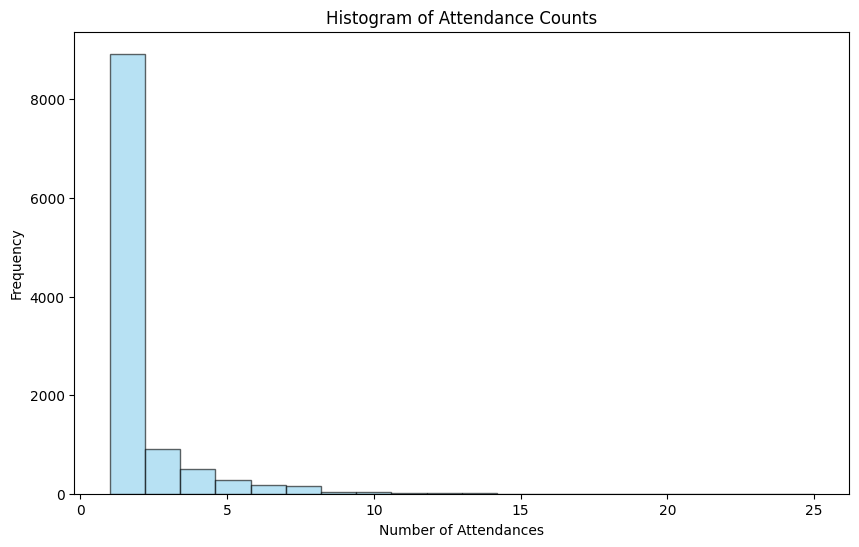

In [8]:
plt.figure(figsize = (10, 6))
plt.hist(engagement_analysis_df['Attendance_Count'], bins = 20, color = 'skyblue', edgecolor = 'black', alpha = 0.6)
plt.title('Histogram of Attendance Counts')
plt.xlabel('Number of Attendances')
plt.ylabel('Frequency')
plt.show()


- High Frequency of Low Attendance: There is a significantly high number of individuals with a low number of attendances, as indicated by the tall bar on the far left. This suggests that the majority of individuals attend health camps only a few times

- Sparse High Attendances: The presence of a few cases with high attendance counts in the 10s and a small number in the 20s range (_really difficult to see in the histogram due to low fequency comapred to the majority but can be seen in the table above this cell_) indicates that there are outliers or exceptional cases where individuals attend very frequently

Overall, the histogram suggests that the health camp has somewhat of a wide reach with many individuals attending at least once, but a smaller core group of individuals attend health camps frequently. It would be helpful to look into the factors that contribute to these high attendance rates among the outliers to understand what drives higher engagement

Box plot for Average Health Scores by Attendance Class

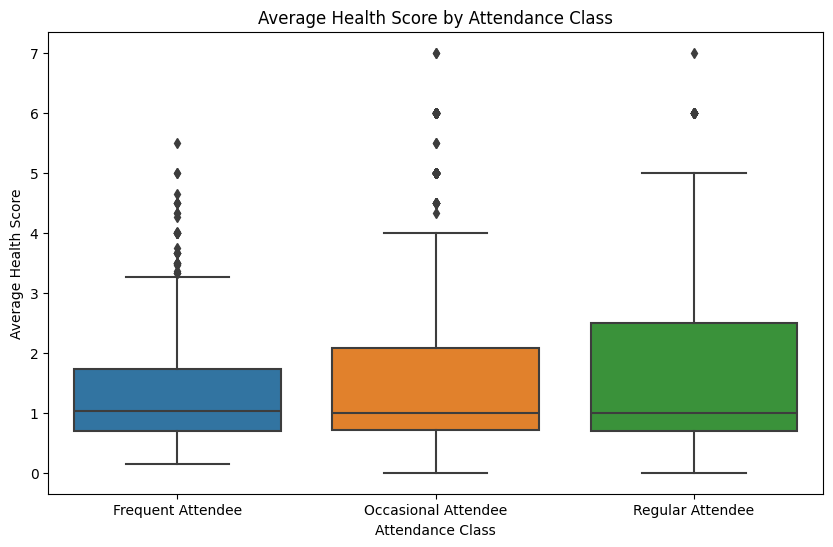

In [9]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Attendance_Class', y = 'Average_Health_Score', data = engagement_analysis_df)
plt.title('Average Health Score by Attendance Class')
plt.xlabel('Attendance Class')
plt.ylabel('Average Health Score')
plt.show()


Looking at the Box plot aobve we can say,

- Frequent Attendees: This group has the highest median average health score, with a relatively narrow interquartile range (IQR), which suggests that frequent attendees generally maintain health scores with less variation compared to other groups

- Regular Attendees: The median average health score for this group is lower than that of frequent attendees. The IQR is broader, indicating more variability in health scores. There are also few outliers indicating that a few regular attendees have unusually high health scores

- Occasional Attendees: This group shows the lowest median average health score among the three classes. Similar to frequent attendees, the IQR is relatively narrower, which shows less variability in health scores, and there are outliers indicating a few occasional attendees with high health scores

Correlation analysis between Donaltion and various types of Online Activities

In [10]:
correlation_linkedin = joined_data.stat.corr("Donation", "LinkedIn_Shared")
correlation_twitter = joined_data.stat.corr("Donation", "Twitter_Shared")
correlation_facebook = joined_data.stat.corr("Donation", "Facebook_Shared")
correlation_follower = joined_data.stat.corr("Donation", "Online_Follower")

# Create a df for correlation results
correlations_data = {
    'Online Activity': ['LinkedIn Shared', 'Twitter Shared', 'Facebook Shared', 'Online Follower'],
    'Correlation with Donation': [correlation_linkedin, correlation_twitter, correlation_facebook, correlation_follower]
}

correlations_df = pd.DataFrame(correlations_data)

correlations_df

,Online Activity,Correlation with Donation
0,LinkedIn Shared,-0.059218
1,Twitter Shared,-0.035428
2,Facebook Shared,-0.038699
3,Online Follower,-0.048907


Bar plot for correlation of Donation and various Online Activities

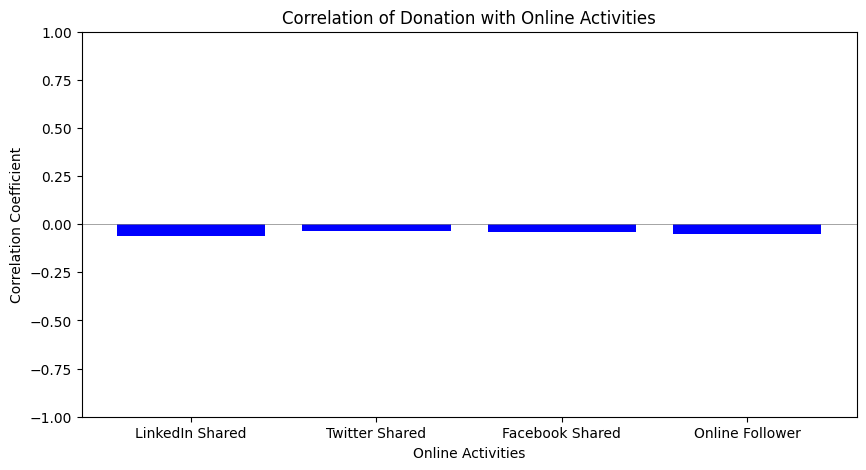

In [11]:
activities = ['LinkedIn Shared', 'Twitter Shared', 'Facebook Shared', 'Online Follower']

correlations = [correlation_linkedin, correlation_twitter, correlation_facebook, correlation_follower]

plt.figure(figsize = (10, 5))
plt.bar(activities, correlations, color = 'blue')
plt.xlabel('Online Activities')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation of Donation with Online Activities')
plt.ylim([-1, 1])
plt.axhline(0, color = 'gray', linewidth = 0.5)
plt.show()

All types of online activity show a negative correlation with donations, which is represented by bars extending below the zero line on the y-axis

The negative correlations depicted might imply that an increase in online sharing or followers does not necessarily lead to an increase or decrease in donations, but could mean an increase in nnumber of attendees. However, it's important to note that correlation does not imply causation, and these findings could tell a better story from further investigation to understand the underlying factors contributing to these relationships

---
Predicting the probability of "**Favorable Outcome**" for the health camps, which is defined as getting a **_Health Score_** for the first 2 health camps and for the third health camp it is defined as visiting at least a stall

In [12]:
# A function to plot ROC curve with AUC form a df containing binary class labels and predicted probabilities for the positive class,
# by calculating ROC curve metrics (fpr, tpr)
def plot_ROC(predictions):
    
    # Convert predictions into a df
    predictions_df = predictions.select("favorable_outcome", "positive_probability").toPandas()
    
    # Calculate ROC metrics
    fpr, tpr, _ = roc_curve(predictions_df['favorable_outcome'], predictions_df['positive_probability'])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)'%roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc = "lower right")
    plt.show()

In [13]:
# Define favorable outcomes for all HC based on the logic that for the first 2 HC if the patitent has a "Health_Score" then it is 1, while for the third HC 
# the patient has to have visited at least one stall for the favorable_outcme to be 1
first_health_camp_attended = first_health_camp_attended.withColumn("favorable_outcome", (col("Health_Score") > 0).cast("integer"))
second_health_camp_attended = second_health_camp_attended.withColumn("favorable_outcome", (col("Health_Score") > 0).cast("integer"))
third_health_camp_attended = third_health_camp_attended.withColumn("favorable_outcome", (col("Number_of_stall_visited") > 0).cast("integer"))

# Combine all the favorable_outcome(s)
favorable_outcomes = first_health_camp_attended.select("Patient_ID", "Health_Camp_ID", "favorable_outcome") \
    .union(second_health_camp_attended.select("Patient_ID", "Health_Camp_ID", "favorable_outcome")) \
    .union(third_health_camp_attended.select("Patient_ID", "Health_Camp_ID", "favorable_outcome"))

# Join train data with favorable_putcome
train_joined = train.join(favorable_outcomes, ["Patient_ID", "Health_Camp_ID"], "left").select(
    train["*"],
    favorable_outcomes["favorable_outcome"]
)

# Handle nulls in favorable_outcome, so that the train data has both classes 0 and 1
train_joined = train_joined.na.fill({'favorable_outcome': 0})

# train_joined.show()

# Select and assemble features
train_selected_features = train_joined.select("Var1", "Var2", "Var3", "Var4", "Var5", "favorable_outcome")
assembler = VectorAssembler(inputCols=["Var1", "Var2", "Var3", "Var4", "Var5"], outputCol = "features")

# Split the data into train and test sets (80% train, 20% test)
train_set, test_set = train_selected_features.randomSplit([0.8, 0.2], seed = 42)

# Define Classification Models
lr = LogisticRegression(featuresCol = "features", labelCol = "favorable_outcome", probabilityCol = "probability")
rf = RandomForestClassifier(featuresCol = "features", labelCol = "favorable_outcome", probabilityCol = "probability", seed = 42)

# Build the pipeline
pipeline_lr = Pipeline(stages = [assembler, lr])
pipeline_rf = Pipeline(stages = [assembler, rf])

# Evaluation
evaluator = BinaryClassificationEvaluator(
    labelCol = "favorable_outcome",
    rawPredictionCol = "positive_probability",
    metricName = "areaUnderROC"
)

### Logistic Regresssion

In [14]:
model_lr = pipeline_lr.fit(train_set)

predictions_lr = model_lr.transform(test_set)

# Using vector_to_array function from pyspark to conver the probability vectors that contains the probabilities for each class into an array
predictions_lr = predictions_lr.withColumn("probability_array", vector_to_array("probability"))

# Extract the positive probability
predictions_lr = predictions_lr.withColumn("positive_probability", col("probability_array")[1])

# Evaluate using ROC-AUC metrics
roc_auc_lr = evaluator.evaluate(predictions_lr)

print("ROC-AUC: ", roc_auc_lr)

ROC-AUC:  0.5191989100941771


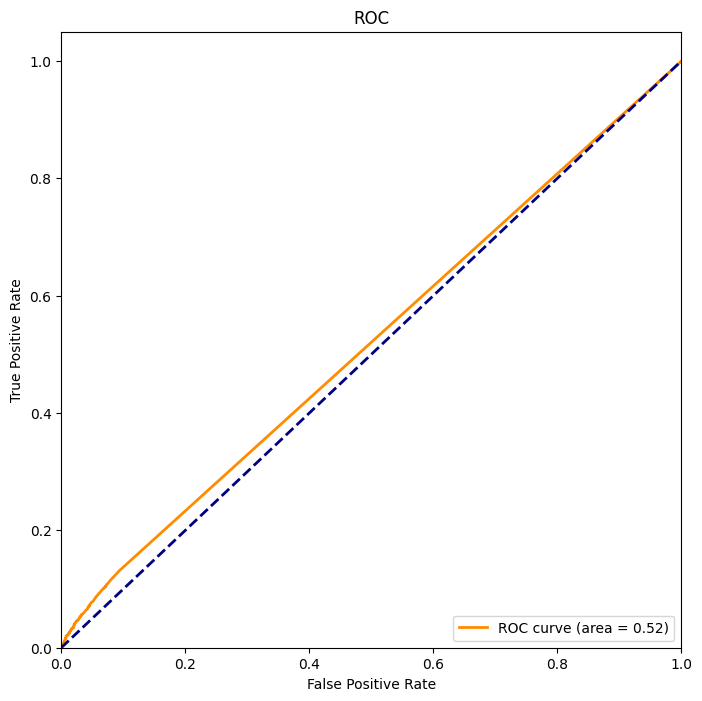

In [15]:
plot_ROC(predictions_lr)

- The ROC curve is slightly above the diagonal blue dashed line, representing a random guess (AUC of 0.5)

- The area under the curve (AUC) is 0.52, which is very close to 0.5. This indicates that the model's ability to discriminate between the positive and negative classes is hardly any better than random guessing

- Since the AUC score is only slightly above 0.5, it suggests that the Logistic Regression model does not perform well on the given data for predicting the "favorable_outcome"

Practically, the model has no usefulness for prediction purposes, and it would likely benefit from further refinement, feature engineering, or potentially using a more complex model that can capture the nuances of the dataset

### RandomForest

In [16]:
model_rf = pipeline_rf.fit(train_set)

# Predict on the test set  
predictions_rf = model_rf.transform(test_set)

# Using vector_to_array function from pyspark to conver the probability vectors that contains the probabilities for each class into an array
predictions_rf = predictions_rf.withColumn("probability_array", vector_to_array("probability"))

# Extract the positive probability
predictions_rf = predictions_rf.withColumn("positive_probability", col("probability_array")[1])

# Evaluate using ROC-AUC metrics
roc_auc_rf = evaluator.evaluate(predictions_rf)

print("ROC-AUC: ", roc_auc_rf)

ROC-AUC:  0.5195011666677574


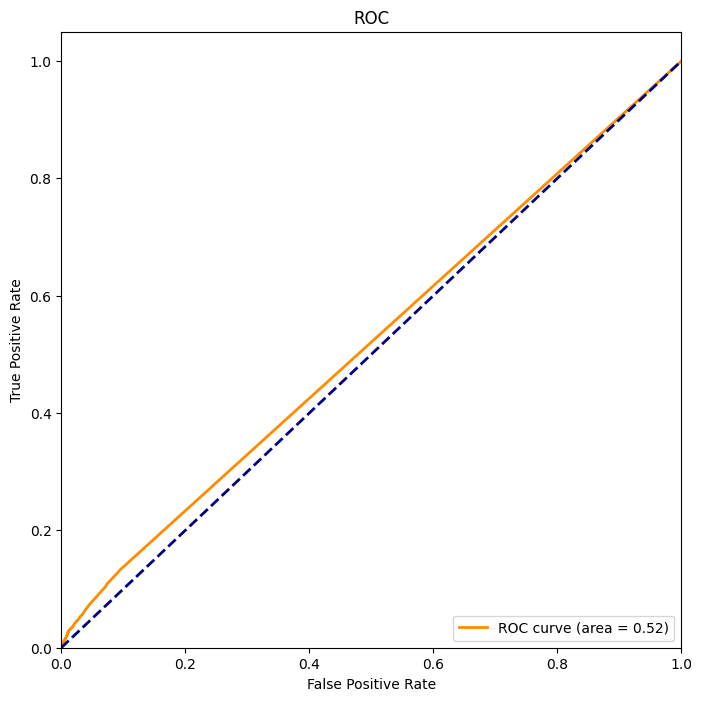

In [17]:
plot_ROC(predictions_rf)

Random Forest classification model shows an AUC score of 0.52, indicating a marginal distinction from random guessing in distinguishing between the positive and negative classes

Compared to Logistic Regression model with a similar AUC score, the Random Forest model does not demonstrate any improvement in probability prediction